# Bees VS Wasps

## Importação de bibliotecas

Essas são todas as bibliotecas necessárias:

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import roc_curve, auc, accuracy_score, mean_squared_error
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold

import matplotlib as mpl
import matplotlib.pyplot as plt

## Pré-processamento

Aqui vem toda a parte de pré-processamento das imagens.

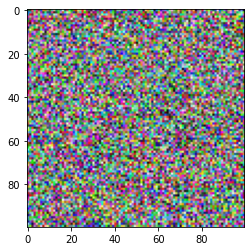

In [10]:
# Used to change filepaths
from pathlib import Path

# We set up matplotlib, pandas, and the display function
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

# import numpy to use in this cell
import numpy as np

# import Image from PIL so we can use it later
from PIL import Image

# generate test_data
test_data=np.random.beta(1,1,size=(100,100,3))

# display the test_data
plt.imshow(test_data)

The image size is: (320, 240)


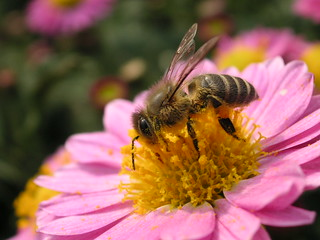

In [12]:
# open the image
img = Image.open('datasets/bee1/1240800_e5f2b40032_n.jpg')

# Get the image size
img_size = img.size

print("The image size is: {}".format(img_size))

# Just having the image as the last line in the cell will display it in the notebook
img

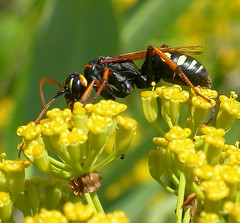

In [15]:
# open the image
img = Image.open('datasets/wasp1/30723011_68d3b0c70b_m.jpg')

# Get the image size
img_size = img.size

# Just having the image as the last line in the cell will display it in the notebook
img

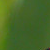

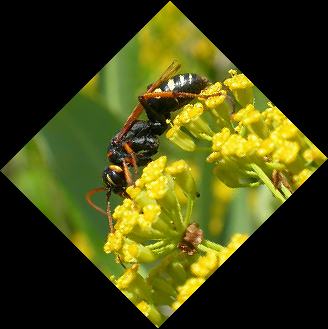

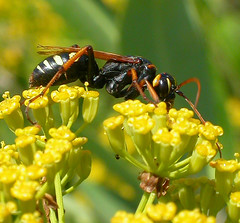

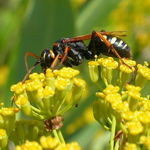

In [19]:
# Crop the image to 25, 25, 75, 75
img_cropped = img.crop([25,25,75,75])
display(img_cropped)

# rotate the image by 45 degrees
img_rotated = img.rotate(45,expand=25)
display(img_rotated)

# flip the image left to right
img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
display(img_flipped)

img_resized = img.resize([150,150])
display(img_resized)

In [2]:
def get_image(row_id, root="datasets/"):
    """
        Opens the image, and returns the image as a numpy array.
    """
    filename = row_id.replace("\\", "/")
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)


def create_features(img):
    # resize 
    img = img.resize([150,150])
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to grayscale
    gray_image = rgb2gray(img)
    # get HOG features from grayscale image
    hog_features = hog(gray_image, block_norm='L2-Hys',
                       pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features


def create_feature_matrix(label_dataframe, total_dados):
    features_list = []
    # contadores de limite de dados
    total_bees = 0
    total_wasp = 0

    for _, row in label_dataframe.iterrows():
        # só considera casos onde é vespa ou abelha e com qualidade de foto boa
        if ((row.is_wasp == 1 and total_wasp < total_dados) or (row.is_bee == 1 and total_bees < total_dados)) and row.photo_quality == 1:
            if row.is_wasp == 1:
                total_wasp = total_wasp + 1
            else:
                total_bees = total_bees + 1

            # load image
            img = get_image(row.path)
            # get features for image
            image_features = create_features(img)
            features_list.append(image_features)

    # convert list of arrays into a matrix
    feature_matrix = np.zeros([len(features_list), len(
        max(features_list, key=lambda x: len(x)))])
    for i, j in enumerate(features_list):
        feature_matrix[i][0:len(j)] = j

    return feature_matrix


def load_bvsw(total_dados=50):
    print("Abrindo arquivo...")
    labels = pd.read_csv("datasets/labels.csv", index_col=0)

    # verifica limite de dados
    if total_dados > 4000:
        total_dados = 4000

    total_dados = total_dados // 2

    print("Criando matriz de features...")
    feature_matrix = create_feature_matrix(labels, total_dados)

    # define standard scaler
    ss = StandardScaler()
    # run this on our feature matrix
    print("Padronizando dados...")
    bees_stand = ss.fit_transform(feature_matrix)

    pca = PCA(n_components=min(500, total_dados*2))
    # use fit_transform to run PCA on our standardized matrix
    print("Rodando PCA (esse processo pode demorar um pouco)...")
    bees_pca = pca.fit_transform(bees_stand)
    # look at new shape
    print('Matriz de PCA concluída com formato: ', bees_pca.shape)

    classes = np.concatenate((np.ones(total_dados), np.zeros(total_dados)))

    return bees_pca, classes

## Classificação

Agora, a parte de definição dos modelos.

A função a seguir define um modelo de acordo com a opção.

In [3]:
def escolhe_modelo(escolha):
    if escolha == '1':
        return SVC(kernel='linear', probability=True, random_state=42)
    elif escolha == '2':
        return GaussianNB()
    elif escolha == '3':
        return DecisionTreeClassifier(random_state=42)
    else:
        print("Opção não existe! Terminando...")
        exit()

Agora, deve-se escolher o modelo e a forma de validação, de acordo com as opções:

**Modelos:**
1. SVM;
2. Naive Bayes;
3. Árvore de decisão.

**Validação:**
1. Holdout repetido;
2. KFold.

In [4]:
escolha = '1' #modelo
validacao = '1'

Também, definir a quantidade de imagens que serão usadas para classificação e quantidade de repetições do método de validação

In [5]:
quantidade_dados = 500  # máximo é 4000
repeticoes = 10

Agora, os dados são carregados.

In [6]:
entrada, saida = load_bvsw(quantidade_dados)

Abrindo arquivo...
Criando matriz de features...
Padronizando dados...
Rodando PCA (esse processo pode demorar um pouco)...
Matriz de PCA concluída com formato:  (500, 500)


Segue o processo de predição:

In [7]:
# para uso da validacao
acertos = []
aucs = []
mses = []
# pra plot de melhor roc
falsos_positivos = []
verdadeiros_positivos = []

if validacao == '1':
    kf = KFold(n_splits=repeticoes, shuffle=True)

    for treino, teste in kf.split(entrada, saida):
        # redefine modelo a cada repeticao
        modelo = escolhe_modelo(escolha)

        # fit model
        modelo.fit(entrada[treino], saida[treino])

        # generate predictions
        predicao = modelo.predict(entrada[teste])

        # calculate accuracy
        acerto = accuracy_score(predicao, saida[teste])
        # predict probabilities for entrada[teste] using predict_proba
        probabilities = modelo.predict_proba(entrada[teste])
        # select the probabilities for label 1.0
        saida_proba = probabilities[:, 1]
        # calculate false positive rate and true positive rate at different thresholds
        false_positive_rate, true_positive_rate, _ = roc_curve(
            saida[teste], saida_proba, pos_label=1)

        # calculate AUC
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # MSE
        mse = mean_squared_error(saida[teste], predicao)

        # guarda resultados
        acertos.append(acerto)
        aucs.append(roc_auc)
        mses.append(mse)
        falsos_positivos.append(false_positive_rate)
        verdadeiros_positivos.append(true_positive_rate)

else:
    # divide em sets de treino e teste
    entrada_treino, entrada_teste, saida_treino, saida_teste = train_test_split(entrada,
                                                                                saida,
                                                                                test_size=.3,
                                                                                random_state=1234123)

    # holdout repetido
    for _ in range(repeticoes):
        # redefine modelo a cada repeticao
        modelo = escolhe_modelo(escolha)

        # fit model
        modelo.fit(entrada_treino, saida_treino)

        # generate predictions
        predicao = modelo.predict(entrada_teste)

        # calculate accuracy
        acerto = accuracy_score(predicao, saida_teste)
        # predict probabilities for entrada_teste using predict_proba
        probabilities = modelo.predict_proba(entrada_teste)
        # select the probabilities for label 1.0
        saida_proba = probabilities[:, 1]
        # calculate false positive rate and true positive rate at different thresholds
        false_positive_rate, true_positive_rate, _ = roc_curve(
            saida_teste, saida_proba, pos_label=1)

        # calculate AUC
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # MSE
        mse = mean_squared_error(saida_teste, predicao)

        # guarda resultados
        acertos.append(acerto)
        aucs.append(roc_auc)
        mses.append(mse)
        falsos_positivos.append(false_positive_rate)
        verdadeiros_positivos.append(true_positive_rate)

Depois de terminado, pode-se exibir alguns resultados:

In [8]:
print("Resultados:\n")
print(f"Acerto médio: {np.average(acertos)} (+-{np.std(acertos)})")
print(f"AUC médio: {np.average(aucs)} (+-{np.std(aucs)})")
print(f"MSE médio: {np.average(mses)} (+-{np.std(mses)})")
melhor_rodada = np.argmax(acertos)
print("Melhor rodada: ", melhor_rodada)

Resultados:

Acerto médio: 0.576 (+-0.061838499334961224)
AUC médio: 0.6377655031124891 (+-0.08114075146305953)
MSE médio: 0.42400000000000004 (+-0.061838499334961224)
Melhor rodada:  6


E também o plot de ROC da melhor rodada:

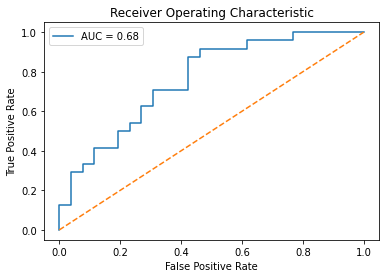

In [9]:
plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
plt.plot(falsos_positivos[melhor_rodada],
         verdadeiros_positivos[melhor_rodada],
         label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0, 1], [0, 1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()